In [ ]:
# Cell 1: Install dependencies (Colab)
!pip -q install lifelines pandas numpy scikit-learn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 11.6 MB/s eta 0:00:00


In [ ]:
# Cell 2: Imports and logging
import json
import logging
from pathlib import Path
from typing import Dict, List, Optional, Sequence, Set, Tuple

import numpy as np
import pandas as pd
from lifelines import CoxPHFitter, WeibullAFTFitter
from lifelines.utils import concordance_index
from sklearn.metrics import precision_recall_curve, roc_auc_score

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger("colab_survival")

In [ ]:
# Cell 3: SurvivalModel implementation (mirrors src/core/ml/survival.py)
class SurvivalModel:
    DEFAULT_CATEGORICAL_FEATURES = [
        "account",
        "type",
        "category",
        "product_type",
        "value_band",
        "season",  # Derived from date_created month - safe, no leakage
    ]
    DEFAULT_NUMERIC_FEATURES = [
        "log_value",
        "new_enquiry_value",
        "created_year",
        "created_quarter",
        "created_month",
    ]
    DEFAULT_INTERACTION_PAIRS: List[Tuple[str, str]] = [
        ("value_band_XLarge (>100k)", "type_New Build"),
        ("value_band_Large (40-100k)", "type_New Build"),
        ("value_band_XLarge (>100k)", "type_Refurbishment"),
    ]

    def __init__(
        self,
        *,
        categorical_features: Optional[Sequence[str]] = None,
        numeric_features: Optional[Sequence[str]] = None,
        penalizer: float = 0.1,
        l1_ratio: float = 0.0,
        max_steps: int = 512,
        category_min_frequency: int = 10,
        enable_interactions: bool = False,
        interaction_pairs: Optional[Sequence[Tuple[str, str]]] = None,
    ) -> None:
        self.categorical_features: List[str] = list(categorical_features or self.DEFAULT_CATEGORICAL_FEATURES)
        self.numeric_features: List[str] = list(numeric_features or self.DEFAULT_NUMERIC_FEATURES)
        self.penalizer = penalizer
        self.l1_ratio = l1_ratio
        self.max_steps = max(1, int(max_steps))
        self.category_min_frequency = max(1, int(category_min_frequency))
        self.enable_interactions = enable_interactions
        self.interaction_pairs: List[Tuple[str, str]] = list(interaction_pairs or self.DEFAULT_INTERACTION_PAIRS)
        self.duration_col = "duration_days"
        self.event_col = "event_observed"
        self.training_columns: List[str] = []
        self.metadata: Dict[str, float] = {}
        self.category_vocab: Dict[str, Set[str]] = {}
        self.cph_model: Optional[CoxPHFitter] = None
        self.aft_model: Optional[WeibullAFTFitter] = None
        self.is_fitted = False

    def fit(
        self,
        df: pd.DataFrame,
        *,
        duration_col: str = "duration_days",
        event_col: str = "event_observed",
        fit_aft: bool = False,
    ) -> Dict[str, float]:
        working = df.copy()
        working = working[(working[duration_col] > 0) & working[event_col].notna()]
        if working.empty:
            raise ValueError("No valid rows available for survival training.")

        self.duration_col = duration_col
        self.event_col = event_col

        feature_matrix = self._encode_features(working, record_training_columns=True)
        model_df = feature_matrix.copy()
        model_df[self.duration_col] = working[self.duration_col].astype(float)
        model_df[self.event_col] = working[self.event_col].astype(int)

        logger.info("Training survival model on %s rows | %s features", len(model_df), len(feature_matrix.columns))

        self.cph_model = CoxPHFitter(penalizer=self.penalizer, l1_ratio=self.l1_ratio)
        fit_options = {"max_steps": self.max_steps, "step_size": 0.95, "precision": 1e-7}
        self.cph_model.fit(
            model_df,
            duration_col=self.duration_col,
            event_col=self.event_col,
            robust=True,
            fit_options=fit_options,
        )

        metrics: Dict[str, float] = {
            "c_index_train": float(getattr(self.cph_model, "concordance_index_", np.nan)),
            "n_rows": float(len(model_df)),
            "n_features": float(len(feature_matrix.columns)),
            "penalizer": float(self.penalizer),
            "l1_ratio": float(self.l1_ratio),
            "max_steps": float(self.max_steps),
            "category_min_frequency": float(self.category_min_frequency),
        }

        if fit_aft:
            try:
                self.aft_model = WeibullAFTFitter(penalizer=0.05)  # try 0.01–0.1
                self.aft_model.fit(
                    model_df,
                    duration_col=self.duration_col,
                    event_col=self.event_col,
                    robust=True,
                )
            except Exception as exc:
                logger.warning("Failed to fit Weibull AFT model: %s", exc)

        self.metadata = metrics
        self.is_fitted = True
        logger.info("Survival training complete | c-index %.4f", metrics["c_index_train"])
        return metrics

    def score(self, df: pd.DataFrame) -> Optional[float]:
        if not self.is_fitted or self.cph_model is None or df.empty:
            return None
        hazards = self.predict_partial_hazard(df)
        if hazards is None:
            return None
        try:
            return float(
                concordance_index(
                    df[self.duration_col].astype(float),
                    -hazards.values,
                    df[self.event_col].astype(int),
                )
            )
        except Exception as exc:
            logger.warning("Unable to compute concordance index: %s", exc)
            return None

    def predict_partial_hazard(self, df: pd.DataFrame) -> Optional[pd.Series]:
        if not self.is_fitted or self.cph_model is None:
            return None
        encoded = self._encode_features(df, record_training_columns=False)
        if encoded.empty:
            return None
        try:
            hazards = self.cph_model.predict_partial_hazard(encoded)
            hazards.index = df.index
            return hazards
        except Exception as exc:
            logger.error("Partial hazard prediction failed: %s", exc)
            return None

    def predict_win_probabilities(
        self,
        project_features: pd.DataFrame,
        *,
        horizons,
        current_age_col: str = "time_open_days",
    ) -> dict:
        if not self.is_fitted or self.cph_model is None or project_features.empty:
            return {h: 0.5 for h in horizons}

        encoded = self._encode_features(project_features, record_training_columns=False)
        if encoded.empty:
            return {h: 0.5 for h in horizons}

        current_age = float(project_features.iloc[0].get(current_age_col, 0.0))
        current_age = max(current_age, 0.0)
        future_ages = [current_age + float(max(h, 0)) for h in horizons]
        times = np.array(sorted({current_age, *future_ages}))

        try:
            surv = self.cph_model.predict_survival_function(encoded, times=times)
        except Exception as exc:
            logger.warning("Failed to compute survival function: %s", exc)
            return {h: 0.5 for h in horizons}

        try:
            s_current = float(surv.loc[current_age].iloc[0])
        except Exception:
            return {h: 0.5 for h in horizons}

        if s_current <= 0:
            return {h: 0.5 for h in horizons}

        results = {}
        for horizon, future_age in zip(horizons, future_ages):
            try:
                s_future = float(surv.loc[future_age].iloc[0])
            except Exception:
                results[horizon] = 0.5
                continue
            conditional = 1.0 - (s_future / s_current)
            results[horizon] = float(min(max(conditional, 0.0), 1.0))
        return results

    def predict_win_probability(
        self,
        project_features: pd.DataFrame,
        horizon_days: int = 30,
        *,
        current_age_col: str = "time_open_days",
    ) -> float:
        probabilities = self.predict_win_probabilities(
            project_features,
            horizons=[horizon_days],
            current_age_col=current_age_col,
        )
        return probabilities.get(horizon_days, 0.5)

    def save(self, path: Path) -> Path:
        if not self.is_fitted:
            raise RuntimeError("Cannot save survival model before fitting.")
        payload = {
            "cph_model": self.cph_model,
            "aft_model": self.aft_model,
            "categorical_features": self.categorical_features,
            "numeric_features": self.numeric_features,
            "duration_col": self.duration_col,
            "event_col": self.event_col,
            "training_columns": self.training_columns,
            "metadata": self.metadata,
            "category_vocab": self.category_vocab,
            "enable_interactions": self.enable_interactions,
            "interaction_pairs": self.interaction_pairs,
        }
        path = Path(path)
        path.parent.mkdir(parents=True, exist_ok=True)
        with path.open("wb") as fh:
            import pickle
            pickle.dump(payload, fh)
        logger.info("Saved survival model artifact → %s", path)
        return path

    def load(self, path: Path) -> None:
        import pickle
        path = Path(path)
        with path.open("rb") as fh:
            payload = pickle.load(fh)
        self.cph_model = payload.get("cph_model")
        self.aft_model = payload.get("aft_model")
        self.categorical_features = payload.get("categorical_features", self.DEFAULT_CATEGORICAL_FEATURES)
        self.numeric_features = payload.get("numeric_features", self.DEFAULT_NUMERIC_FEATURES)
        self.duration_col = payload.get("duration_col", "duration_days")
        self.event_col = payload.get("event_col", "event_observed")
        self.training_columns = payload.get("training_columns", [])
        self.metadata = payload.get("metadata", {})
        self.category_vocab = payload.get("category_vocab", {})
        self.enable_interactions = payload.get("enable_interactions", False)
        self.interaction_pairs = payload.get("interaction_pairs", self.DEFAULT_INTERACTION_PAIRS)
        self.is_fitted = self.cph_model is not None
        logger.info("Loaded survival model artifact from %s", path)

    # internal helpers
    def _category_allowlist(self, col: str, series: pd.Series, record_training_columns: bool) -> set:
        fallback: set = {"Other"}
        if series.empty:
            return self.category_vocab.get(col, fallback)
        if record_training_columns or col not in self.category_vocab:
            counts = series.value_counts()
            allowed = set(counts[counts >= self.category_min_frequency].index)
            allowed.add("Other")
            self.category_vocab[col] = allowed
        return self.category_vocab.get(col, fallback)

    def _encode_features(self, df: pd.DataFrame, *, record_training_columns: bool) -> pd.DataFrame:
        working = df.copy()
        for col in self.categorical_features:
            series = (
                working.get(col)
                .fillna("Unknown")
                .astype(str)
                .str.strip()
                .replace("", "Unknown")
            )
            allowlist = self._category_allowlist(col, series, record_training_columns)
            working[col] = series.where(series.isin(allowlist), other="Other")
        for col in self.numeric_features:
            working[col] = pd.to_numeric(working.get(col), errors="coerce").fillna(0.0)
        encoded = pd.get_dummies(
            working[self.categorical_features + self.numeric_features],
            columns=self.categorical_features,
            drop_first=False,
            dtype=float,
        )
        if self.enable_interactions:
            encoded = self._add_interaction_features(encoded)
        if record_training_columns or not self.training_columns:
            self.training_columns = list(encoded.columns)
        encoded = encoded.reindex(columns=self.training_columns, fill_value=0.0)
        return encoded

    def _add_interaction_features(self, encoded: pd.DataFrame) -> pd.DataFrame:
        for col_a, col_b in self.interaction_pairs:
            if col_a in encoded.columns and col_b in encoded.columns:
                interaction_name = f"interaction_{col_a}_x_{col_b}"
                encoded[interaction_name] = encoded[col_a] * encoded[col_b]
        return encoded

In [ ]:
# Cell 4: Helper functions (mirrors scripts/train_survival.py and scripts/evaluate_survival.py)
def prepare_dataset(df: pd.DataFrame, min_duration: int = 5) -> pd.DataFrame:
    cleaned = df.copy()
    required_cols = {"duration_days", "event_observed"}
    missing = required_cols - set(cleaned.columns)
    if missing:
        raise ValueError(f"Dataset missing required columns: {missing}")

    cleaned = cleaned[cleaned["duration_days"].fillna(0) >= min_duration]
    cleaned = cleaned[cleaned["event_observed"].notna()]
    cleaned = cleaned.reset_index(drop=True)
    if cleaned.empty:
        raise ValueError("No rows left after filtering for survival training.")
    return cleaned

def temporal_split(df: pd.DataFrame, val_size: float = 0.2):
    if val_size <= 0 or val_size >= 1:
        return df, pd.DataFrame()
    df = df.copy()
    df["date_created"] = pd.to_datetime(df["date_created"], errors="coerce")
    df_sorted = df.sort_values("date_created").reset_index(drop=True)
    split_idx = int(len(df_sorted) * (1 - val_size))
    train_df = df_sorted.iloc[:split_idx].reset_index(drop=True)
    val_df = df_sorted.iloc[split_idx:].reset_index(drop=True)
    return train_df, val_df

def filter_for_horizon_evaluation(df: pd.DataFrame, horizon_days: int) -> pd.DataFrame:
    df = df.copy()
    resolved_mask = df["event_observed"] == 1
    if "censor_reason" in df.columns:
        resolved_mask = resolved_mask | (df["censor_reason"] == "lost")
    if "status_category" in df.columns:
        resolved_mask = resolved_mask | df["status_category"].isin(["Lost", "Closed"])
    open_long_enough = (df["event_observed"] == 0) & (df["duration_days"] >= horizon_days)
    valid_mask = resolved_mask | open_long_enough
    return df[valid_mask].reset_index(drop=True)

def prepare_horizon_labels(df: pd.DataFrame, horizon_days: int = 90) -> pd.Series:
    labels = (df["duration_days"] <= horizon_days) & (df["event_observed"] == 1)
    return labels.astype(int)

def compute_roc_pr(probabilities: np.ndarray, labels: np.ndarray) -> Dict[str, Optional[float]]:
    if len(np.unique(labels)) < 2:
        return {"roc_auc": None, "pr_auc": None}
    roc_auc = roc_auc_score(labels, probabilities)
    precision, recall, _ = precision_recall_curve(labels, probabilities)
    pr_auc = np.trapezoid(precision[::-1], recall[::-1])
    return {"roc_auc": float(roc_auc), "pr_auc": float(pr_auc)}

def predict_probabilities_batch(model: SurvivalModel, df: pd.DataFrame, horizon_days: int, backtest_mode: bool = True) -> np.ndarray:
    probs = []
    for idx in range(len(df)):
        row_df = df.iloc[[idx]].copy()
        if backtest_mode:
            row_df["time_open_days"] = 0
        prob = model.predict_win_probabilities(row_df, horizons=[horizon_days])[horizon_days]
        probs.append(prob)
    return np.array(probs)


In [ ]:
# Cell 5: Load the snapshot
# If the CSV is in Colab's /content, set csv_path accordingly.
csv_path = "/content/data/survival_training_20251215_034140.csv"  # adjust if needed
df_raw = pd.read_csv(csv_path)
df_raw.head(), df_raw.shape

(                                     id   monday_id  item_name  \
 0  f0fd0028-6974-4d0d-9d10-a0cdaacaaae3  2561259174      17745   
 1  d35d7c1e-938e-407d-8010-f16468ec8454  2561235519      17744   
 2  af737c93-67cb-4b1b-95f8-d41b333de425  2561146119      17743   
 3  086cfed5-9c70-41df-8b3c-05b3a909e141  2560598604      17742   
 4  52e7b3d6-a51e-4979-afd5-5a1395291dfe  2560456510      17741   
 
                                         project_name pipeline_stage  \
 0                                 Linlithgow Academy   Open Enquiry   
 1                                   Whitburn Academy   Open Enquiry   
 2  Bankside Yards Gym, Southwark Street, LONDON S...   Open Enquiry   
 3  Eden House, Bodens Cottage, Bodens Ride, Winkf...   Open Enquiry   
 4                             Kingsbrook Nature Park   Open Enquiry   
 
             type   category zip_code sales_representative funding  ...  \
 0  Refurbishment  Education       EH       Gary Bottomley     NaN  ...   
 1  Refurbis

In [ ]:
# Cell 6: Prepare data and temporal split
dataset = prepare_dataset(df_raw, min_duration=5)
train_df, val_df = temporal_split(dataset, val_size=0.2)
len(train_df), len(val_df)

(3631, 908)

In [ ]:
# Cell 7: Train the survival model (CoxPH) and optional AFT
model = SurvivalModel(
    penalizer=0.5,          # match your script defaults
    l1_ratio=0.1,
    max_steps=512,
    category_min_frequency=10,
    enable_interactions=False,  # set True to enable interaction pairs
)

train_metrics = model.fit(
    train_df,
    duration_col="duration_days",
    event_col="event_observed",
    fit_aft=True,
)
train_metrics

{'c_index_train': 0.9858468897718808,
 'n_rows': 3631.0,
 'n_features': 105.0,
 'penalizer': 0.5,
 'l1_ratio': 0.1,
 'max_steps': 512.0,
 'category_min_frequency': 10.0}

In [ ]:
# Cell 8: Validation c-index
val_c_index = model.score(val_df) if not val_df.empty else None
val_c_index

0.9480625982368619

In [ ]:
# Cell 9: Horizon evaluation (mirrors evaluate_survival.py)
horizon_days = 270
backtest_mode = True  # simulate prediction at project creation (time_open_days=0)

val_df_filtered = filter_for_horizon_evaluation(val_df, horizon_days) if not val_df.empty else pd.DataFrame()
roc_metrics = {"roc_auc": None, "pr_auc": None}

if not val_df_filtered.empty and val_df_filtered["event_observed"].sum() > 0:
    probs = predict_probabilities_batch(model, val_df_filtered, horizon_days, backtest_mode=backtest_mode)
    labels = prepare_horizon_labels(val_df_filtered, horizon_days=horizon_days).to_numpy()
    roc_metrics = compute_roc_pr(probs, labels)

roc_metrics, len(val_df_filtered)


({'roc_auc': 0.7238675958188153, 'pr_auc': 0.8872263880329668}, 110)

In [ ]:
# Cell 10: Multi-horizon evaluation (optional)
horizons_to_test = [30, 60, 90, 120, 180, 270, 365]
multi_horizon_results = {}

if not val_df.empty:
    for h in horizons_to_test:
        h_filtered = filter_for_horizon_evaluation(val_df, h)
        if h_filtered.empty:
            multi_horizon_results[h] = {"roc_auc": None, "pr_auc": None, "n_positive": 0, "n_total": 0, "positive_rate": 0}
            continue
        h_labels = prepare_horizon_labels(h_filtered, horizon_days=h)
        n_positive = int(h_labels.sum())
        n_total = len(h_labels)
        positive_rate = n_positive / n_total if n_total > 0 else 0
        if n_positive == 0 or n_positive == n_total:
            multi_horizon_results[h] = {
                "roc_auc": None,
                "pr_auc": None,
                "n_positive": n_positive,
                "n_total": n_total,
                "positive_rate": positive_rate,
            }
            continue
        h_probs = predict_probabilities_batch(model, h_filtered, h, backtest_mode=backtest_mode)
        h_metrics = compute_roc_pr(h_probs, h_labels.to_numpy())
        multi_horizon_results[h] = {
            **h_metrics,
            "n_positive": n_positive,
            "n_total": n_total,
            "positive_rate": round(positive_rate, 4),
        }

multi_horizon_results


{30: {'roc_auc': 0.5,
  'pr_auc': 0.5061443932411674,
  'n_positive': 8,
  'n_total': 651,
  'positive_rate': 0.0123},
 60: {'roc_auc': 0.5,
  'pr_auc': 0.5161579892280072,
  'n_positive': 18,
  'n_total': 557,
  'positive_rate': 0.0323},
 90: {'roc_auc': 0.5,
  'pr_auc': 0.5283018867924528,
  'n_positive': 27,
  'n_total': 477,
  'positive_rate': 0.0566},
 120: {'roc_auc': 0.5,
  'pr_auc': 0.5489690721649485,
  'n_positive': 38,
  'n_total': 388,
  'positive_rate': 0.0979},
 180: {'roc_auc': 0.5,
  'pr_auc': 0.649789029535865,
  'n_positive': 71,
  'n_total': 237,
  'positive_rate': 0.2996},
 270: {'roc_auc': 0.7238675958188153,
  'pr_auc': 0.8872263880329668,
  'n_positive': 82,
  'n_total': 110,
  'positive_rate': 0.7455},
 365: {'roc_auc': 0.7238675958188153,
  'pr_auc': 0.8872263880329668,
  'n_positive': 82,
  'n_total': 110,
  'positive_rate': 0.7455}}

In [ ]:
# Cell 11: Save artifacts to Colab (optional)
artifact_path = Path("/content/survival_v1_colab.pkl")
metrics_path = artifact_path.with_suffix(".json")

model.save(artifact_path)
metadata = {
    "model_version": "v1_colab",
    "artifact_path": str(artifact_path),
    "snapshot_path": csv_path,
    "split_method": "temporal",
    "train_concordance": train_metrics.get("c_index_train"),
    "val_concordance": val_c_index,
    "n_train_rows": train_metrics.get("n_rows"),
    "n_features": train_metrics.get("n_features"),
    "evaluation_metrics": {
        "roc_auc": roc_metrics.get("roc_auc"),
        "pr_auc": roc_metrics.get("pr_auc"),
        "multi_horizon_results": multi_horizon_results,
    },
}
with metrics_path.open("w", encoding="utf-8") as fh:
    json.dump(metadata, fh, indent=2)

artifact_path, metrics_path

(PosixPath('/content/survival_v1_colab.pkl'),
 PosixPath('/content/survival_v1_colab.json'))

###**Multi-Horizon ROC-AUC Bar Chart**

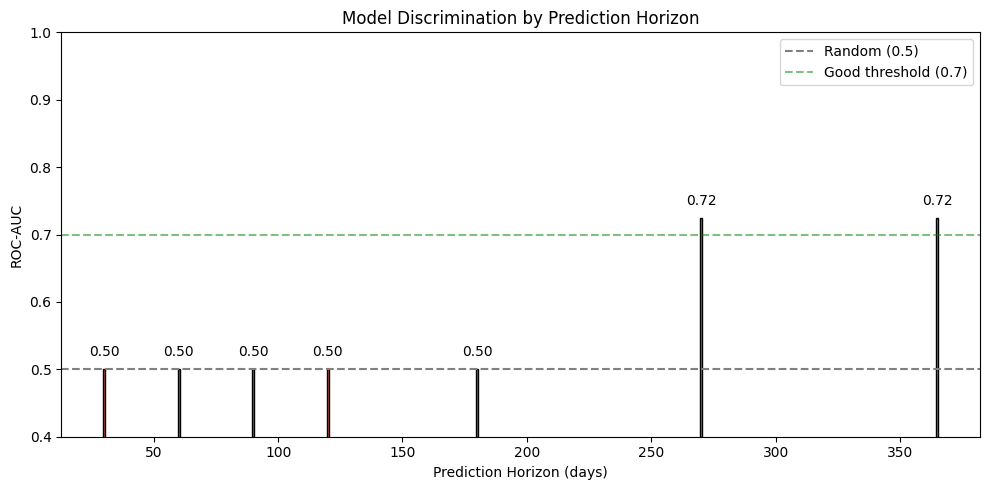

In [ ]:
import matplotlib.pyplot as plt

horizons = [30, 60, 90, 120, 180, 270, 365]
roc_aucs = [0.5, 0.5, 0.5, 0.5, 0.5, 0.724, 0.724]  # from your results

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#d9534f' if x <= 0.55 else '#5cb85c' for x in roc_aucs]
bars = ax.bar(horizons, roc_aucs, color=colors, edgecolor='black')
ax.axhline(y=0.5, color='gray', linestyle='--', label='Random (0.5)')
ax.axhline(y=0.7, color='green', linestyle='--', alpha=0.5, label='Good threshold (0.7)')
ax.set_xlabel('Prediction Horizon (days)')
ax.set_ylabel('ROC-AUC')
ax.set_title('Model Discrimination by Prediction Horizon')
ax.set_ylim(0.4, 1.0)
ax.legend()
for bar, val in zip(bars, roc_aucs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.2f}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

###**Kaplan-Meier Survival Curves by Risk Group**

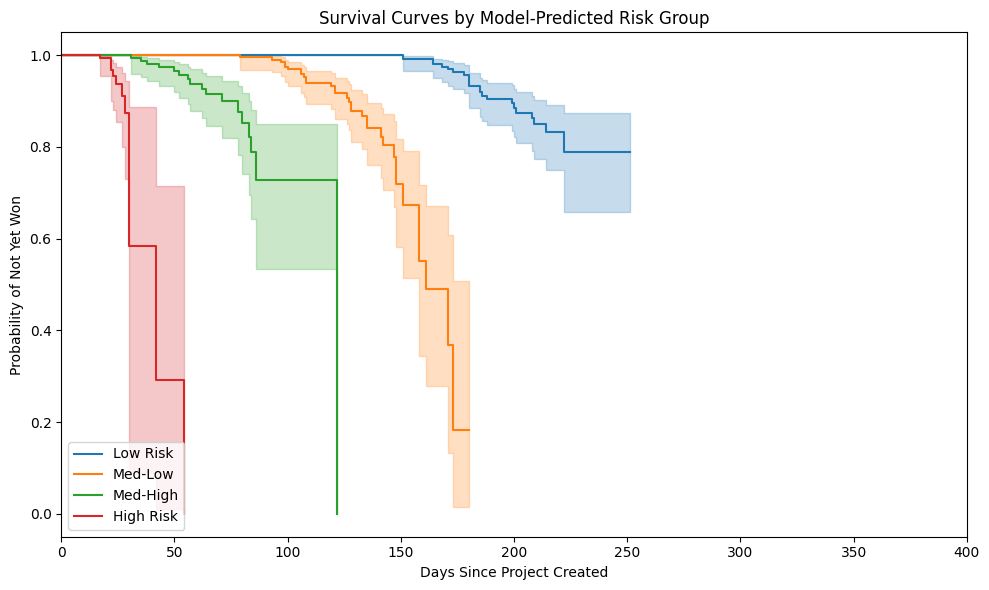

In [ ]:
from lifelines import KaplanMeierFitter

# Get hazard predictions and create risk groups
hazards = model.predict_partial_hazard(val_df)
val_df['risk_group'] = pd.qcut(hazards, q=4, labels=['Low Risk', 'Med-Low', 'Med-High', 'High Risk'])

fig, ax = plt.subplots(figsize=(10, 6))
kmf = KaplanMeierFitter()

for group in ['Low Risk', 'Med-Low', 'Med-High', 'High Risk']:
    mask = val_df['risk_group'] == group
    kmf.fit(val_df.loc[mask, 'duration_days'],
            val_df.loc[mask, 'event_observed'],
            label=group)
    kmf.plot_survival_function(ax=ax)

ax.set_xlabel('Days Since Project Created')
ax.set_ylabel('Probability of Not Yet Won')
ax.set_title('Survival Curves by Model-Predicted Risk Group')
ax.set_xlim(0, 400)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

###**Calibration Plot at 270 Days**

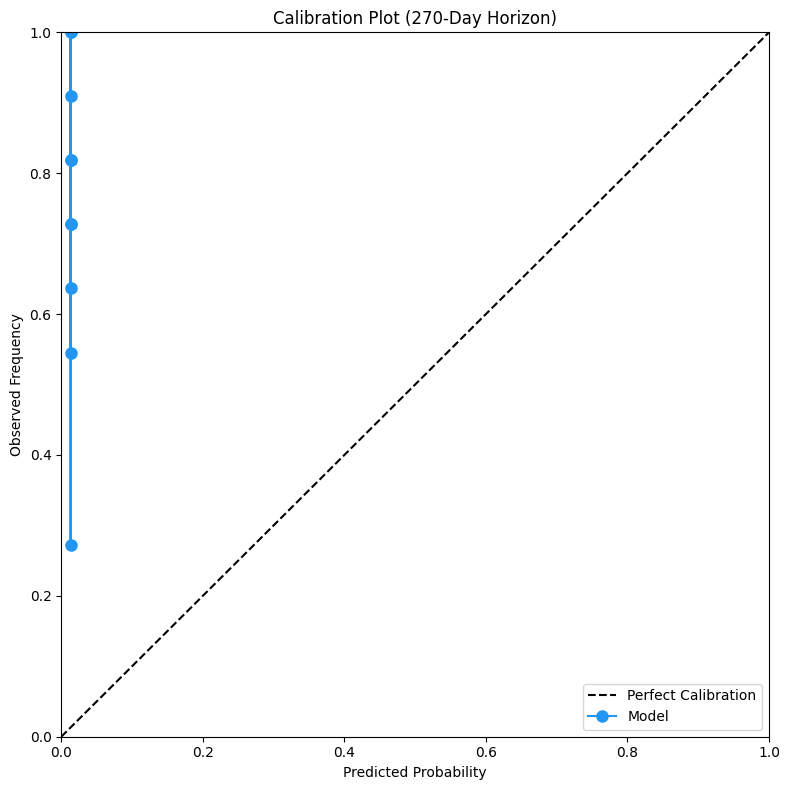

In [ ]:
from sklearn.calibration import calibration_curve

# Get 270-day predictions and labels (Distorted by Backtesting)
probs_270 = predict_probabilities_batch(model, val_df_filtered, 270, backtest_mode=True)
labels_270 = prepare_horizon_labels(val_df_filtered, 270).to_numpy()

prob_true, prob_pred = calibration_curve(labels_270, probs_270, n_bins=10, strategy='quantile')

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
ax.plot(prob_pred, prob_true, 'o-', color='#2196F3', label='Model', markersize=8)
ax.fill_between(prob_pred, prob_true - 0.1, prob_true + 0.1, alpha=0.2)
ax.set_xlabel('Predicted Probability')
ax.set_ylabel('Observed Frequency')
ax.set_title('Calibration Plot (270-Day Horizon)')
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

###**ROC Curve at 270 Days (Stakeholder-Friendly)**

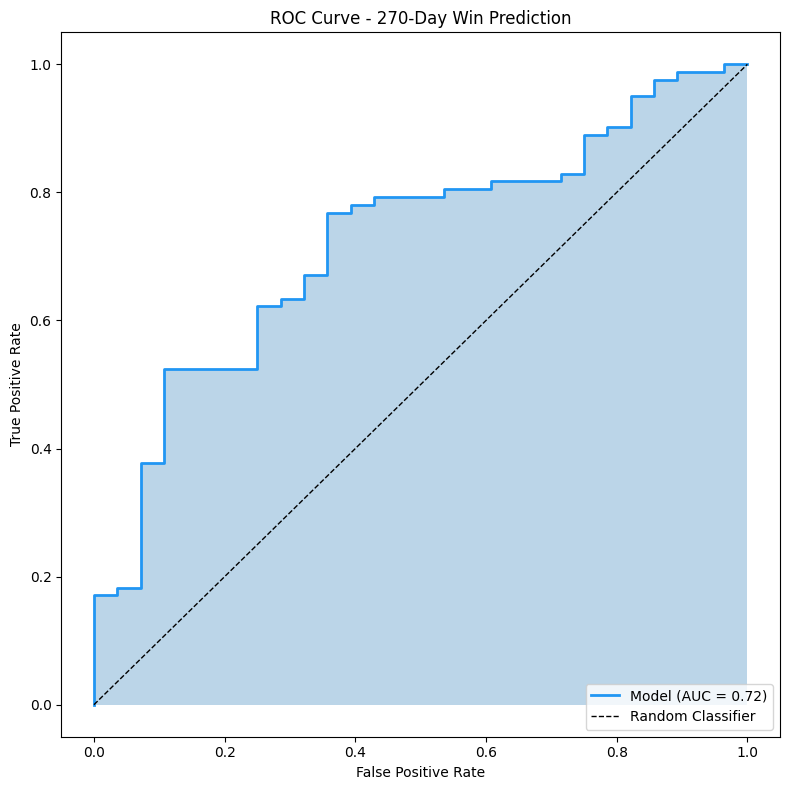

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(labels_270, probs_270)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr, tpr, color='#2196F3', lw=2, label=f'Model (AUC = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')
ax.fill_between(fpr, tpr, alpha=0.3)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve - 270-Day Win Prediction')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

###**Feature Importance (Coefficient Plot)**

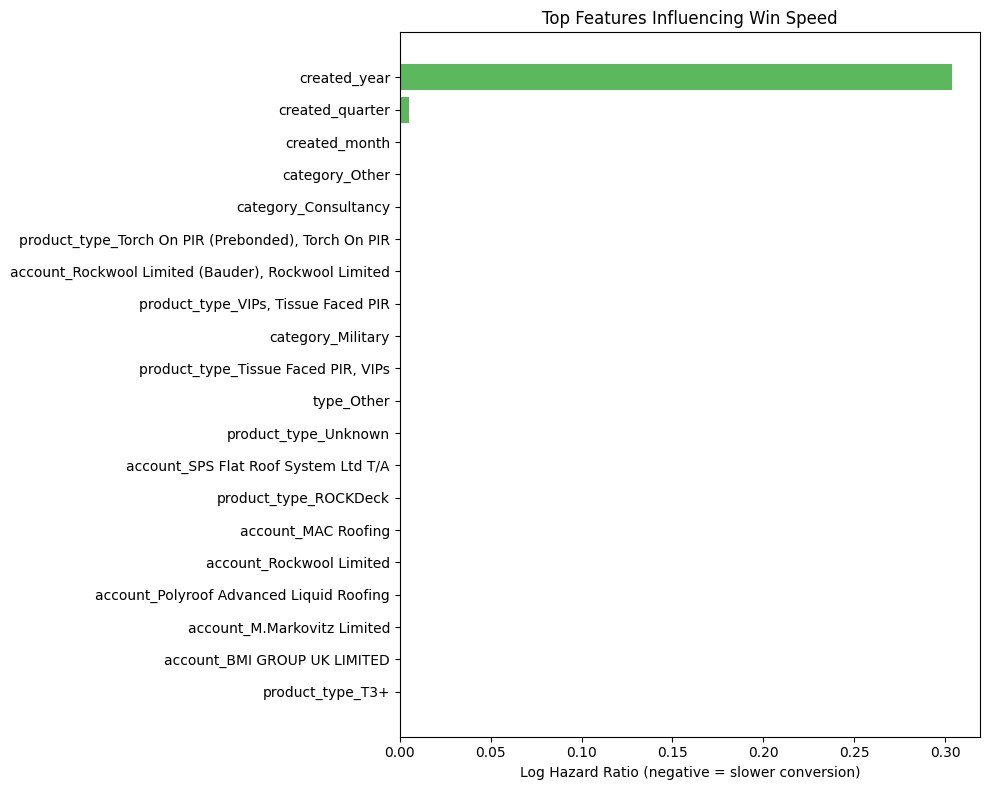

In [ ]:
# Extract coefficients from Cox model
coefs = model.cph_model.params_.sort_values()

# Top 15 most influential features
top_features = pd.concat([coefs.head(10), coefs.tail(10)])

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#d9534f' if x < 0 else '#5cb85c' for x in top_features.values]
ax.barh(range(len(top_features)), top_features.values, color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features.index)
ax.axvline(x=0, color='black', lw=0.5)
ax.set_xlabel('Log Hazard Ratio (negative = slower conversion)')
ax.set_title('Top Features Influencing Win Speed')
plt.tight_layout()
plt.show()

###**Precision-Recall Curve (For Imbalanced Data)**

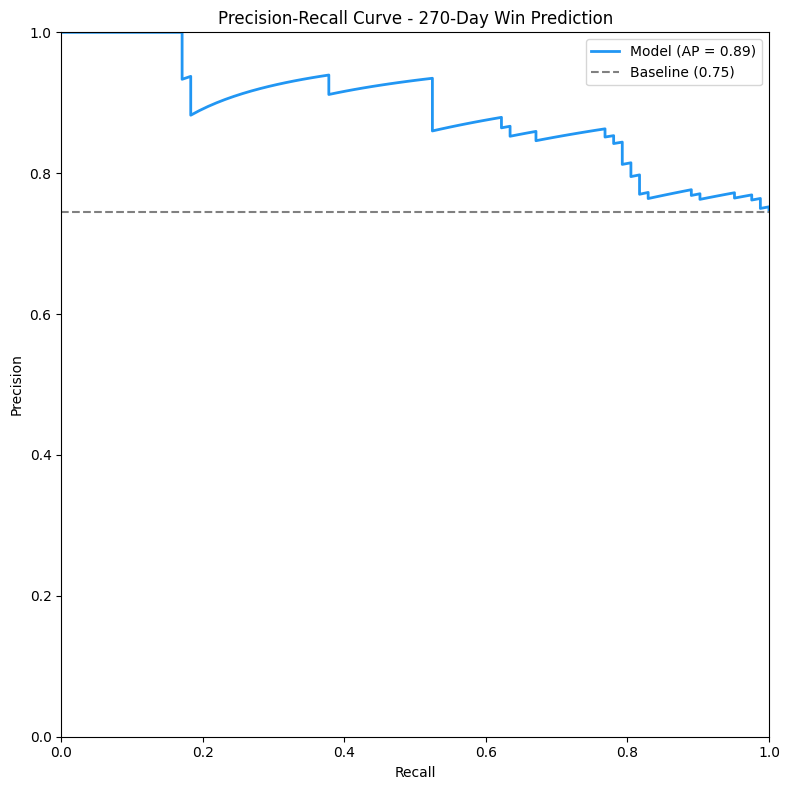

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(labels_270, probs_270)
ap = average_precision_score(labels_270, probs_270)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(recall, precision, color='#2196F3', lw=2, label=f'Model (AP = {ap:.2f})')
ax.axhline(y=labels_270.mean(), color='gray', linestyle='--',
           label=f'Baseline ({labels_270.mean():.2f})')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve - 270-Day Win Prediction')
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

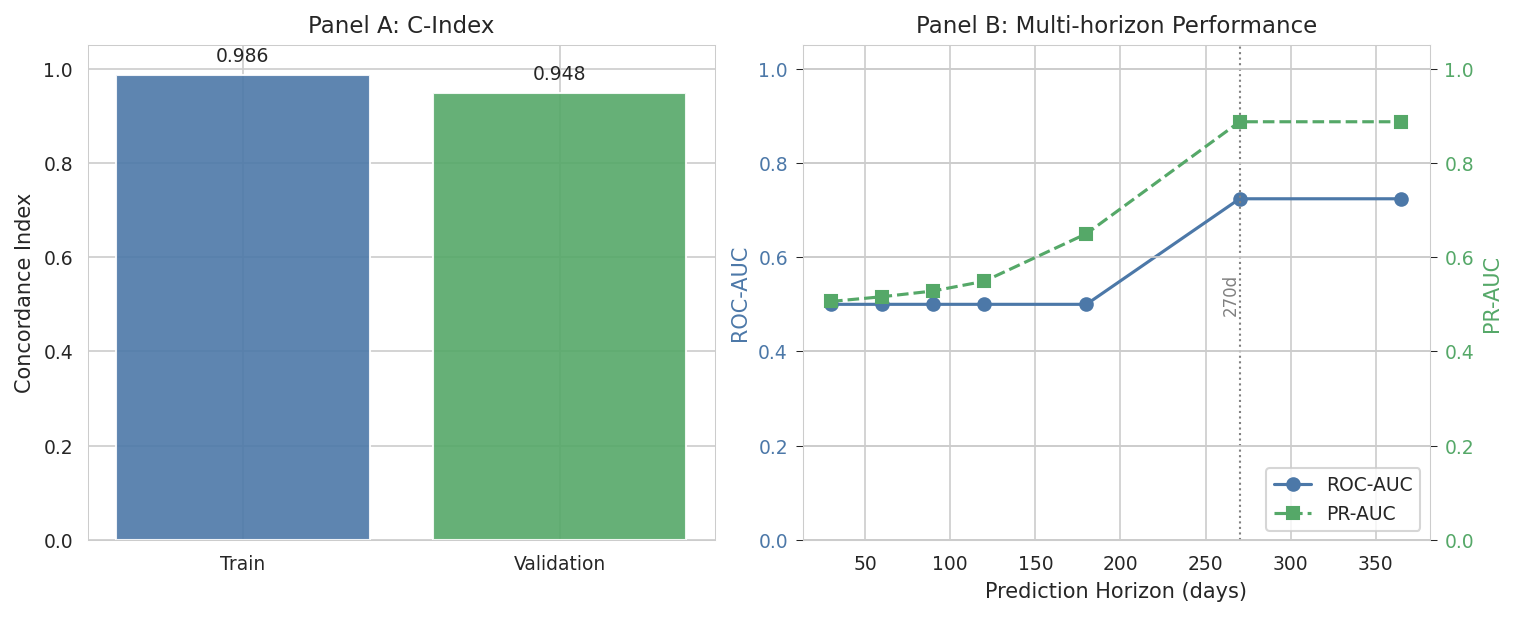

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
sns.set_palette("colorblind")

# --- Data from evaluation (documented horizons) ---
train_c = 0.9858468897718808
val_c   = 0.9480625982368619

horizons = np.array([30, 60, 90, 120, 180, 270, 365])
roc_auc = np.array([0.50, 0.50, 0.50, 0.50, 0.50, 0.7238675958188153, 0.7238675958188153])
pr_auc  = np.array([0.5061443932411674, 0.5161579892280072, 0.5283018867924528,
                    0.5489690721649485, 0.649789029535865, 0.8872263880329668,
                    0.8872263880329668])
pos_rate = np.array([0.0123, 0.0323, 0.0566, 0.0979, 0.2996, 0.7455, 0.7455])  # optional

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# Panel A: Train vs Val C-index (bar chart)
ax1.bar(["Train", "Validation"], [train_c, val_c], color=["#4C78A8", "#55A868"], alpha=0.9)
ax1.set_ylim(0.0, 1.05)
ax1.set_ylabel("Concordance Index")
for i, v in enumerate([train_c, val_c]):
    ax1.text(i, v + 0.02, f"{v:.3f}", ha="center", va="bottom", fontsize=9)
ax1.set_title("Panel A: C-Index")

# Panel B: Multi-horizon ROC-AUC (left y) and PR-AUC (right y)
ax2.set_title("Panel B: Multi-horizon Performance")
color_roc = "#4C78A8"
color_pr  = "#55A868"  # green for validation metrics

ax2.plot(horizons, roc_auc, marker="o", color=color_roc, label="ROC-AUC")
ax2.set_xlabel("Prediction Horizon (days)")
ax2.set_ylabel("ROC-AUC", color=color_roc)
ax2.tick_params(axis="y", labelcolor=color_roc)
ax2.set_ylim(0.0, 1.05)

ax2b = ax2.twinx()
ax2b.plot(horizons, pr_auc, marker="s", linestyle="--", color=color_pr, label="PR-AUC")
ax2b.set_ylabel("PR-AUC", color=color_pr)
ax2b.tick_params(axis="y", labelcolor=color_pr)
ax2b.set_ylim(0.0, 1.05)

# Optional: highlight key horizon (270d)
ax2.axvline(270, color="gray", linestyle=":", linewidth=1)
ax2.text(270, 0.52, "270d", rotation=90, ha="right", va="center", fontsize=8, color="gray")

# Legend combining both axes
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2b.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="lower right", frameon=True)

plt.show()

###**Actual Duration by Risk Quartile**

/tmp/ipython-input-297493191.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


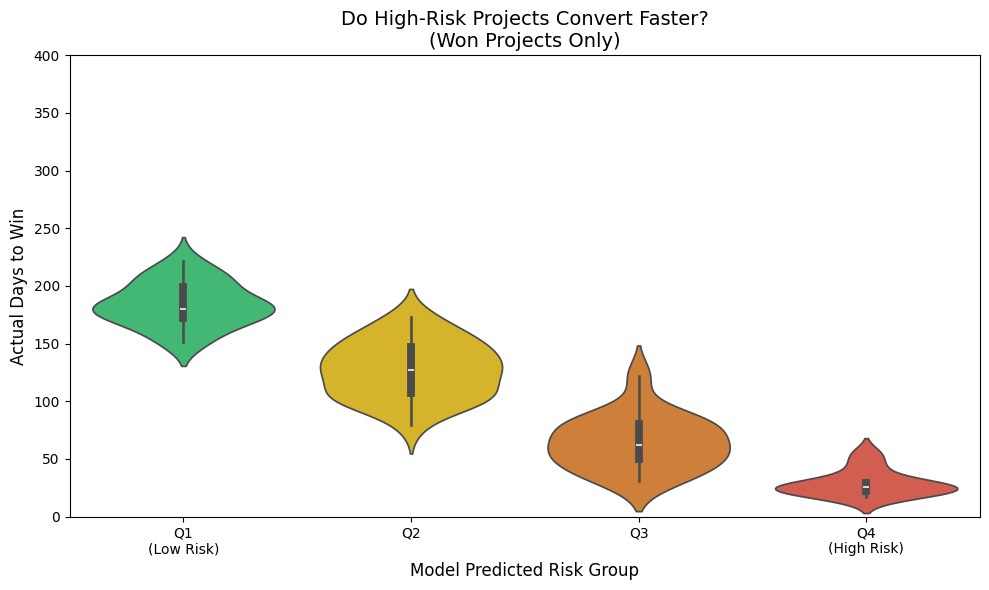

In [ ]:
# Cell: Duration Distribution by Predicted Risk Group
import matplotlib.pyplot as plt
import seaborn as sns

# Get hazard predictions and create risk groups
hazards = model.predict_partial_hazard(val_df)
val_df_plot = val_df.copy()
val_df_plot['risk_quartile'] = pd.qcut(
    hazards, q=4, labels=['Q1\n(Low Risk)', 'Q2', 'Q3', 'Q4\n(High Risk)']
)

# Filter to won projects only (they have actual conversion times)
won_df = val_df_plot[val_df_plot['event_observed'] == 1].copy()

fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(
    data=won_df,
    x='risk_quartile',
    y='duration_days',
    palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
    ax=ax
)
ax.set_xlabel('Model Predicted Risk Group', fontsize=12)
ax.set_ylabel('Actual Days to Win', fontsize=12)
ax.set_title('Do High-Risk Projects Convert Faster?\n(Won Projects Only)', fontsize=14)
ax.set_ylim(0, 400)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2178202691.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




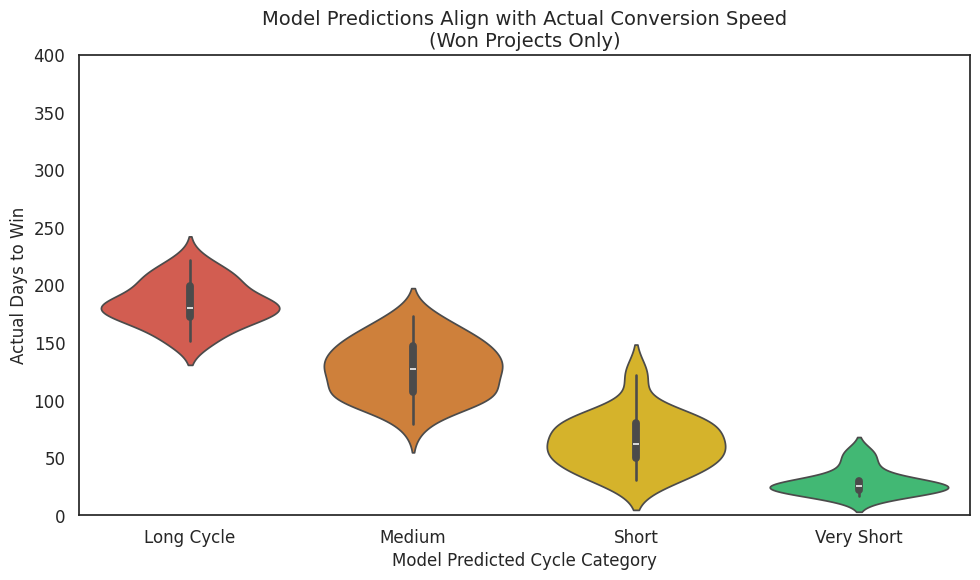

In [ ]:
# Cell: Duration Distribution by Predicted Risk Group
import matplotlib.pyplot as plt
import seaborn as sns

# Get hazard predictions and create risk groups
hazards = model.predict_partial_hazard(val_df)
val_df_plot = val_df.copy()
val_df_plot['prospect_status'] = pd.qcut(
    hazards, q=4, labels=['Long Cycle', 'Medium', 'Short', 'Very Short']
)

# Filter to won projects only (they have actual conversion times)
won_df = val_df_plot[val_df_plot['event_observed'] == 1].copy()

fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(
#sns.boxplot(
    data=won_df,
    x='prospect_status',
    y='duration_days',
    #palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
    palette=['#e74c3c', '#e67e22', '#f1c40f', '#2ecc71'],  # Red → Green
    ax=ax
)
ax.set_xlabel('Model Predicted Cycle Category', fontsize=12)
ax.set_ylabel('Actual Days to Win', fontsize=12)
ax.set_title('Model Predictions Align with Actual Conversion Speed\n(Won Projects Only)', fontsize=14)
ax.set_ylim(0, 400)
plt.tight_layout()
plt.show()

/tmp/ipython-input-3943753689.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




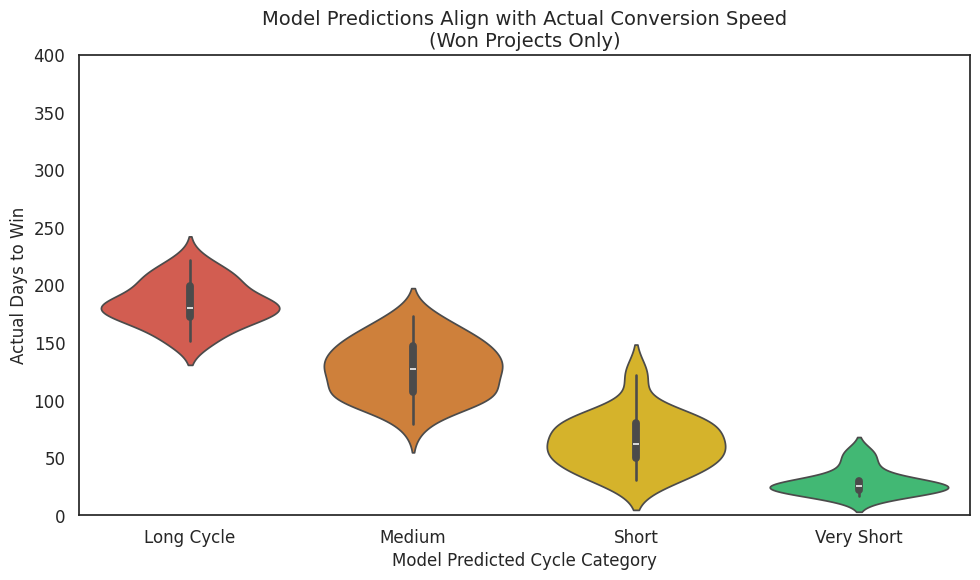

In [ ]:
# Cell: Duration Distribution by Predicted Risk Group
import matplotlib.pyplot as plt
import seaborn as sns


# Get hazard predictions and create risk groups
hazards = model.predict_partial_hazard(val_df)
val_df_plot = val_df.copy()
val_df_plot['prospect_status'] = pd.qcut(
    hazards, q=4, labels=['Long Cycle', 'Medium', 'Short', 'Very Short']
)

# Filter to won projects only (they have actual conversion times)
won_df = val_df_plot[val_df_plot['event_observed'] == 1].copy()

fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(
#sns.boxplot(
    data=won_df,
    x='prospect_status',
    y='duration_days',
    #palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
    palette=['#e74c3c', '#e67e22', '#f1c40f', '#2ecc71'],  # Red → Green
    ax=ax
)
ax.set_xlabel('Model Predicted Cycle Category', fontsize=12)
ax.set_ylabel('Actual Days to Win', fontsize=12)
ax.set_title('Model Predictions Align with Actual Conversion Speed\n(Won Projects Only)', fontsize=14)
ax.set_ylim(0, 400)


plt.tight_layout()


plt.show()

/tmp/ipython-input-3790939108.py:32: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved: cycle_category_validation.png and .pdf


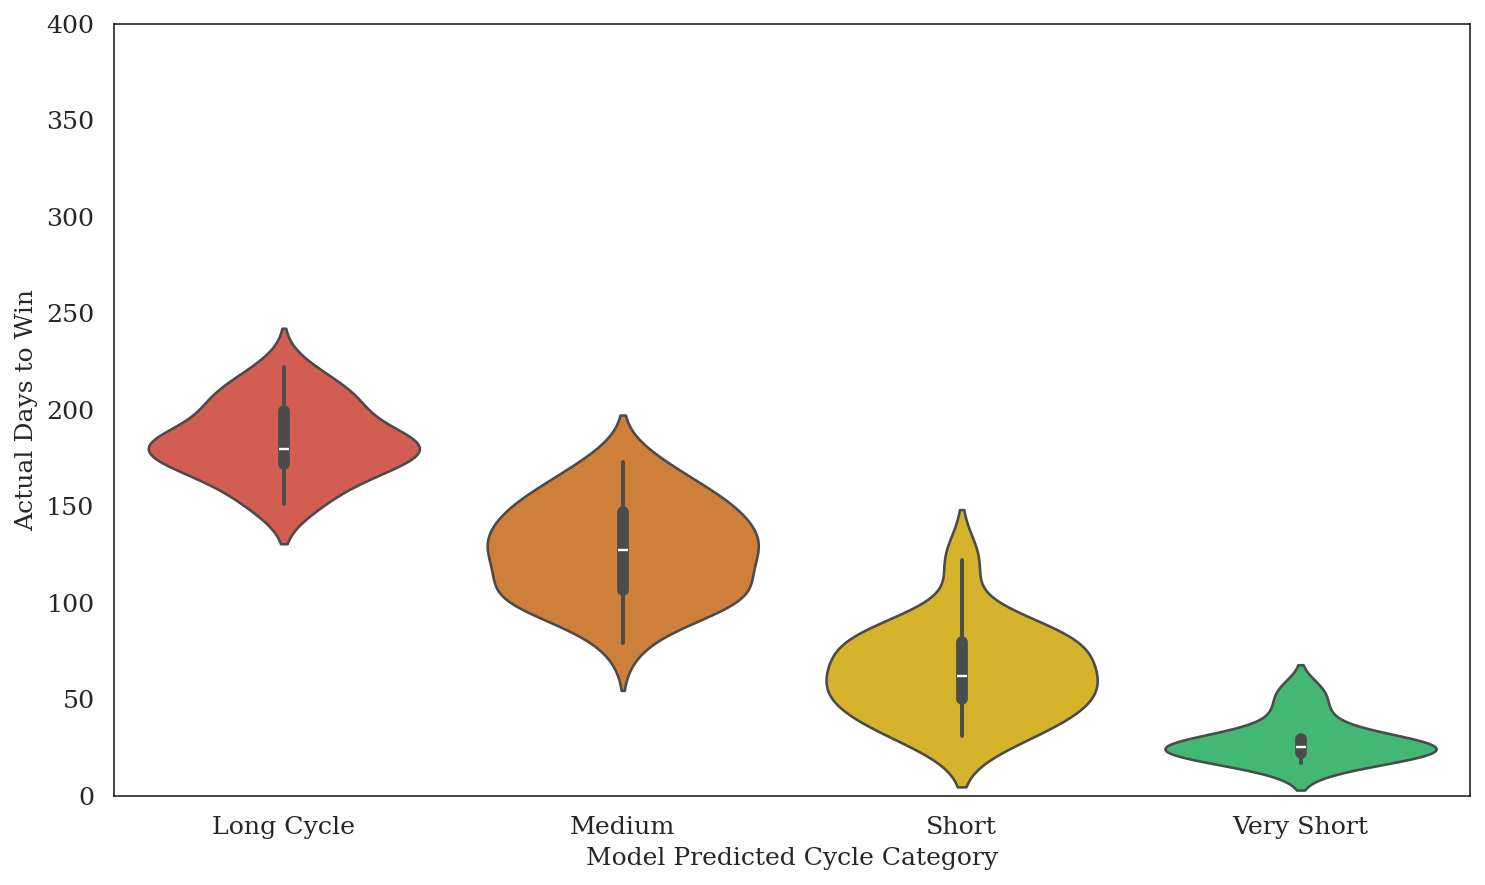

In [ ]:
# Cell: Duration Distribution by Predicted Risk Group
import matplotlib.pyplot as plt
import seaborn as sns

# Apply theme BEFORE creating the plot
sns.set_theme(style="white", palette="muted", font_scale=1.1)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.family'] = 'sans-serif'

# Publication-quality settings
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'figure.dpi': 150,  # Display DPI
})

# Get hazard predictions and create risk groups
hazards = model.predict_partial_hazard(val_df)
val_df_plot = val_df.copy()
val_df_plot['prospect_status'] = pd.qcut(
    hazards, q=4, labels=['Long Cycle', 'Medium', 'Short', 'Very Short']
)

# Filter to won projects only (they have actual conversion times)
won_df = val_df_plot[val_df_plot['event_observed'] == 1].copy()

fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(
    data=won_df,
    x='prospect_status',
    y='duration_days',
    palette=['#e74c3c', '#e67e22', '#f1c40f', '#2ecc71'],  # Red → Green
    ax=ax
)
ax.set_xlabel('Model Predicted Cycle Category', fontsize=12)
ax.set_ylabel('Actual Days to Win', fontsize=12)
#ax.set_title('Model Predictions Align with Actual Conversion Speed\n(Won Projects Only)', fontsize=14)
ax.set_ylim(0, 400)

plt.tight_layout()

# Save BEFORE plt.show() (show() can clear the figure)
fig.savefig('/content/cycle_category_validation.pdf', bbox_inches='tight', facecolor='white')
fig.savefig('/content/cycle_category_validation.eps', format='eps', bbox_inches='tight', facecolor='white')
print("Saved: cycle_category_validation.png and .pdf")

plt.show()

/tmp/ipython-input-1341185575.py:42: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




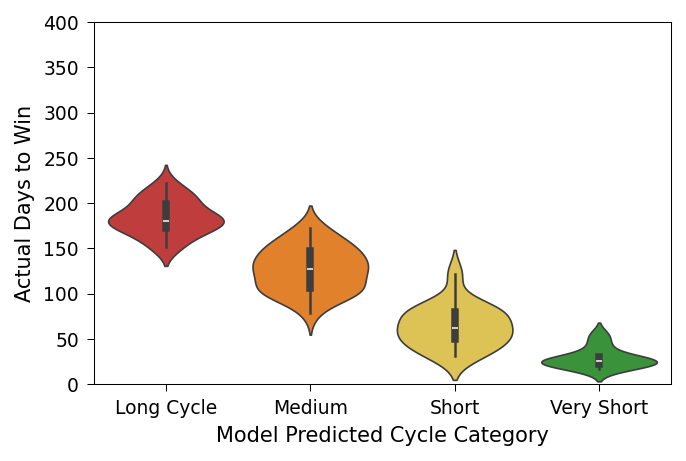

In [ ]:
# Cell: Duration Distribution by Predicted Cycle Category (Publication Quality)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Reset to defaults first, then apply clean settings
mpl.rcdefaults()

# Publication-quality settings (LaTeX-friendly)
plt.rcParams.update({
    # 'font.family': 'serif',
    # 'font.serif': ['Times New Roman', 'Times', 'DejaVu Serif'],
    'font.size': 9,
    'axes.labelsize': 10,
    'axes.titlesize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'axes.linewidth': 0.5,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.grid': False,
    'figure.dpi': 150,
})

# Get hazard predictions and create risk groups
hazards = model.predict_partial_hazard(val_df)
val_df_plot = val_df.copy()
val_df_plot['prospect_status'] = pd.qcut(
    hazards, q=4, labels=['Long Cycle', 'Medium', 'Short', 'Very Short']
)

# Filter to won projects only
won_df = val_df_plot[val_df_plot['event_observed'] == 1].copy()

# SIZE: Match to column width (3.5" for single column, ~3.3" for 0.48\textwidth of 7")
fig, ax = plt.subplots(figsize=(4.5, 3.0))  # Inches - fits 0.48\textwidth nicely

# Use seaborn with explicit settings (no theme override)
sns.violinplot(
    data=won_df,
    x='prospect_status',
    y='duration_days',
    palette=['#d62728', '#ff7f0e', '#f4d03f', '#2ca02c'],  # Cleaner color palette
    linewidth=0.8,
    ax=ax
)

ax.set_xlabel('Model Predicted Cycle Category')
ax.set_ylabel('Actual Days to Win')
ax.set_ylim(0, 400)

# Clean up spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.tight_layout(pad=0.5)

fig.savefig('/content/cycle_category_validation.pdf',
            format='pdf',
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none',
            pad_inches=0.02)

fig.savefig('/content/cycle_category_validation.eps',
            format='eps',
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none',
            pad_inches=0.02)

plt.show()